In [2]:
import torch
import scanpy as sc
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix, issparse
from sklearn.preprocessing import normalize
import ot 
from sklearn.neighbors import NearestNeighbors

In [3]:
def construct_graph_torch(X, k, mode='connectivity', metric = 'minkowski', p=2, device='cuda'):
    '''construct knn graph with torch and gpu
    args:
        X: input data containing features (torch tensor)
        k: number of neighbors for each data point
        mode: 'connectivity' or 'distance'
        metric: distance metric (now euclidean supported for gpu knn)
        p: param for minkowski (not used if metric is euclidean)
    
    Returns:
        knn graph as a pytorch sparse tensor (coo format) or dense tensor depending on mode     
    '''

    assert mode in ['connectivity', 'distance'], "mode must be 'connectivity' or 'distance'."
    assert metric == 'euclidean', "for gpu knn, only 'euclidean' metric is currently supported in this implementation"

    if mode == 'connectivity':
        include_self = True
        mode_knn = 'connectivity'
    else:
        include_self = False
        mode_knn = 'distance'

    n_samples = X.shape[0]
    knn = NearestNeighbors(n_neighbors=k, metric=metric, algorithm='auto')

    if device == 'cuda' and torch.cuda.is_available():
        X_cpu = X.cpu().numpy()
    else:
        X_cpu = X.numpy()

    knn.fit(X_cpu)
    knn_graph_cpu = kneighbors_graph(knn, k, mode=mode_knn, include_self=include_self, metric=metric) #scipy sparse matrix on cpu
    knn_graph_coo = knn_graph_cpu.tocoo()

    if mode == 'connectivity':
        knn_graph = torch.sparse_coo_tensor(torch.LongTensor([knn_graph_coo.row, knn_graph_coo.col]),
                                            torch.FloatTensor(knn_graph_coo.data),
                                            size = knn_graph_coo.shape).to(device)
    elif mode == 'distance':
        knn_graph_dense = torch.tensor(knn_graph_cpu.toarray(), dtype=torch.float32, device=device) #move to gpu as dense tensor
        knn_graph = knn_graph_dense
    
    return knn_graph
    
def distances_cal_torch(graph, type_aware=None, aware_power =2, device='cuda'):
    '''
    calculate distance matrix from graph using dijkstra's algo
    args:
        graph: knn graph (pytorch sparse or dense tensor)
        type_aware: not implemented in this torch version for simplicity
        aware_power: same ^^
        device (str): 'cpu' or 'cuda' device to use
    Returns:
        distance matrix as a torch tensor
    '''

    if isinstance(graph, torch.Tensor) and graph.is_sparse:
        graph_cpu_csr = csr_matrix(graph.cpu().to_dense().numpy())
    elif isinstance(graph, torch.Tensor) and not graph.is_sparse:
        graph_cpu_csr = csr_matrix(graph.cpu().numpy())
    else:
        graph_cpu_csr = csr_matrix(graph) #assume scipy sparse matrix if not torch tensor

    shortestPath_cpu = dijkstra(csgraph = graph_cpu_csr, directed=False, return_predecessors=False) #dijkstra on cpu
    shortestPath = torch.tensor(shortestPath_cpu, dtype=torch.float32, device=device)

    # the_max = torch.nanmax(shortestPath[shortestPath != float('inf')])
    # shortestPath[shortestPath > the_max] = the_max

    #mask out infinite distances
    mask = shortestPath != float('inf')
    if mask.any():
        the_max = torch.max(shortestPath[mask])
        shortestPath[~mask] = the_max #replace inf with max value
    else:
        the_max = 1.0 #fallback if all are inf (should not happen in connected graphs)

    C_dis = shortestPath / the_max
    C_dis -= torch.mean(C_dis)
    return C_dis

def calculate_D_sc_torch(X_sc, k_neighbors=10, graph_mode='connectivity', device='cpu'):
    '''calculate distance matrix from graph using dijkstra's algo
    args:
        graph: knn graph (torch sparse or dense tensor)
        type_aware: not implemented
        aware_power: same ^^
        
    returns:
        distanced matrix as torch tensor'''
    
    if not isinstance(X_sc, torch.Tensor):
        raise TypeError('Input X_sc must be a pytorch tensor')
    
    if device == 'cuda' and torch.cuda.is_available():
        X_sc = X_sc.cuda(device=device)
    else:
        X_sc = X_sc.cpu()
        device= 'cpu'

    print(f'using device: {device}')
    print(f'constructing knn graph...')
    # X_normalized = normalize(X_sc.cpu().numpy(), norm='l2') #normalize on cpu for sklearn knn
    X_normalized = X_sc
    X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)

    Xgraph = construct_graph_torch(X_normalized_torch, k=k_neighbors, mode=graph_mode, metric='euclidean', device=device)

    print('calculating distances from graph....')
    D_sc = distances_cal_torch(Xgraph, device=device)

    print('D_sc calculation complete')
    
    return D_sc


In [4]:
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from scipy.sparse.csgraph import dijkstra
from scipy.sparse import csr_matrix, issparse
from sklearn.preprocessing import normalize
import ot

def construct_graph_spatial(location_array, k, mode='distance', metric='euclidean', p=2):
    '''construct KNN graph based on spatial coordinates
    args:
        location_array: spatial coordinates of spots (n-spots * 2)
        k: number of neighbors for each spot
        mode: 'connectivity' or 'distance'
        metric: distance metric for knn (p=2 is euclidean)
        p: param for minkowski if connectivity
        
    returns:
        scipy.sparse.csr_matrix: knn graph in csr format
    '''

    assert mode in ['connectivity', 'distance'], "mode must be 'connectivity' or 'distance'"
    if mode == 'connectivity':
        include_self = True
    else:
        include_self = False
    
    c_graph = kneighbors_graph(location_array, k, mode=mode, metric=metric, include_self=include_self, p=p)
    return c_graph

def distances_cal_spatial(graph, spot_ids=None, spot_types=None, aware_power=2):
    '''calculate spatial distance matrix from knn graph
    args:
        graph (scipy.sparse.csr_matrix): knn graph
        spot_ids (list, optional): list of spot ids corresponding to the rows/cols of the graph. required if type_aware is used
        spot_types (pd.Series, optinal): pandas series of spot types for type aware distance adjustment. required if type_aware is used
        aware_power (int): power for type-aware distance adjustment
        
    returns:
        sptial distance matrix'''
    shortestPath = dijkstra(csgraph = csr_matrix(graph), directed=False, return_predecessors=False)
    shortestPath = np.nan_to_num(shortestPath, nan=np.inf) #handle potential inf valyes after dijkstra

    if spot_types is not None and spot_ids is not None:
        shortestPath_df = pd.DataFrame(shortestPath, index=spot_ids, columns=spot_ids)
        shortestPath_df['id1'] = shortestPath_df.index
        shortestPath_melted = shortestPath_df.melt(id_vars=['id1'], var_name='id2', value_name='value')

        type_aware_df = pd.DataFrame({'spot': spot_ids, 'spot_type': spot_types}, index=spot_ids)
        meta1 = type_aware_df.copy()
        meta1.columns = ['id1', 'type1']
        meta2 = type_aware_df.copy()
        meta2.columns = ['id2', 'type2']

        shortestPath_melted = pd.merge(shortestPath_melted, meta1, on='id1', how='left')
        shortestPath_melted = pd.merge(shortestPath_melted, meta2, on='id2', how='left')

        shortestPath_melted['same_type'] = shortestPath_melted['type1'] == shortestPath_melted['type2']
        shortestPath_melted.loc[(~shortestPath_melted.smae_type), 'value'] = shortestPath_melted.loc[(~shortestPath_melted.same_type),
                                                                                                     'value'] * aware_power
        shortestPath_melted.drop(['type1', 'type2', 'same_type'], axis=1, inplace=True)
        shortestPath_pivot = shortestPath_melted.pivot(index='id1', columns='id2', values='value')

        order = spot_ids
        shortestPath = shortestPath_pivot[order].loc[order].values
    else:
        shortestPath = np.asarray(shortestPath) #ensure it's a numpy array

    #mask out infinite distances
    mask = shortestPath != float('inf')
    if mask.any():
        the_max = np.max(shortestPath[mask])
        shortestPath[~mask] = the_max #replace inf with max value
    else:
        the_max = 1.0 #fallback if all are inf (should not happen in connected graphs)

    C_dis = shortestPath / the_max
    C_dis -= np.mean(C_dis)

    return C_dis

def calculate_D_st_from_coords(spatial_coords, X_st=None, k_neighbors=10, graph_mode='distance', aware_st=False, 
                               spot_types=None, aware_power_st=2, spot_ids=None):
    '''calculates the spatial distance matrix D_st for spatial transcriptomics data directly from coordinates and optional spot types
    args:
        spatial_coords: spatial coordinates of spots (n_spots * 2)
        X_st: St gene expression data (not used for D_st calculation itself)
        k_neighbors: number of neighbors for knn graph
        graph_mode: 'connectivity or 'distance' for knn graph
        aware_st: whether to use type-aware distance adjustment
        spot_types: pandas series of spot types for type-aware adjustment
        aware_power_st: power for type-aware distance adjustment
        spot_ids: list or index of spot ids, required if spot_ids is provided
        
    returns:
        np.ndarray: spatial disance matrix D_st'''
    
    if isinstance(spatial_coords, pd.DataFrame):
        location_array = spatial_coords.values
        if spot_ids is None:
            spot_ids = spatial_coords.index.tolist() #use index of dataframe if available
    elif isinstance(spatial_coords, np.ndarray):
        location_array = spatial_coords
        if spot_ids is None:
            spot_ids = list(range(location_array.shape[0])) #generate default ids if not provided

    else:
        raise TypeError('spatial_coords must be a pandas dataframe or a numpy array')
    
    print(f'constructing {graph_mode} graph for ST data with k={k_neighbors}.....')
    Xgraph_st = construct_graph_spatial(location_array, k=k_neighbors, mode=graph_mode)
    
    if aware_st:
        if spot_types is None or spot_ids is None:
            raise ValueError('spot_types and spot_ids must be provided when aware_st=True')
        if not isinstance(spot_types, pd.Series):
            spot_types = pd.Series(spot_types, idnex=spot_ids) 
        print('applying type aware distance adjustment for ST data')
        print(f'aware power for ST: {aware_power_st}')
    else:
        spot_types = None 

    print(f'calculating spatial distances.....')
    D_st = distances_cal_spatial(Xgraph_st, spot_ids=spot_ids, spot_types=spot_types, aware_power=aware_power_st)

    print('D_st calculation complete')
    return D_st


In [5]:
def fused_gw_torch(X_sc, X_st, Y_st, alpha, k=100, G0=None, max_iter = 100, tol=1e-9, device='cuda', n_iter = 1):
    n = X_sc.shape[0]
    m = X_st.shape[0]

    X_sc = X_sc.to(device)
    X_st = X_st.to(device)

    if not torch.is_tensor(Y_st):
        Y_st_tensor = torch.tensor(Y_st, dtype=torch.float32, device=device)
    else:
        Y_st_tensor = Y_st.to(device, dtype=torch.float32)

    #calculate distance matrices
    print('calculating SC distances with knn-dijkstra.....')
    D_sc = calculate_D_sc_torch(X_sc, k_neighbors=k, device=device)

    print('Calculating ST distances.....')
    D_st = calculate_D_st_from_coords(spatial_coords=Y_st, k_neighbors=15, graph_mode="distance") # Using calculate_D_st_from_coords
    D_st = torch.tensor(D_st, dtype=torch.float32, device=device) # Convert D_st to tensor and move to device

    #get expression distance matrix
    C_exp = torch.cdist(X_sc, X_st, p=2) #euclidean distance
    C_exp = C_exp / (torch.max(C_exp) + 1e-16) #normalize

    #ensure distance matries are C-contiguouse numpy arrays for POT
    D_sc_np = D_sc.cpu().numpy()
    D_st_np = D_st.cpu().numpy()
    C_exp_np = C_exp.cpu().numpy()
    D_sc_np = np.ascontiguousarray(D_sc_np)
    D_st_np = np.ascontiguousarray(D_st_np)
    C_exp_np = np.ascontiguousarray(C_exp_np)

    #uniform distributions
    p = ot.unif(n)
    q = ot.unif(m)

    #anneal the reg param over several steps
    T_np = None
    for i in range(n_iter):
        #run fused gw with POT
        T_np, log = ot.gromov.fused_gromov_wasserstein(
            M=C_exp_np, C1=D_sc_np, C2=D_st_np,
            p=p, q=q, loss_fun='square_loss',
            alpha=alpha,
            G0=T_np if T_np is not None else (G0.cpu().numpy() if G0 is not None else None),
            log=True,
            verbose=True,
            max_iter = max_iter,
            tol_abs=tol
        )

    fgw_dist = log['fgw_dist']

    print(f'fgw distance: {fgw_dist}')

    T = torch.tensor(T_np, dtype=torch.float32, device=device)

    return T, D_sc, D_st, fgw_dist

In [6]:
scdata = pd.read_csv('./data/mousedata_2020/E1z2/simu_sc_counts.csv',index_col=0)
scdata = scdata.T
stdata = pd.read_csv('data/mousedata_2020/E1z2/simu_st_counts.csv',index_col=0)
stdata = stdata.T
stgtcelltype = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_celltype.csv',index_col=0)
spcoor = pd.read_csv('./data/mousedata_2020/E1z2/simu_st_metadata.csv',index_col=0)
scmetadata = pd.read_csv('./data/mousedata_2020/E1z2/metadata.csv',index_col=0)

adata = sc.AnnData(scdata,obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata = pd.DataFrame(adata.X,index=adata.obs_names,columns=adata.var_names)
stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata = pd.DataFrame(stadata.X,index=stadata.obs_names,columns=stadata.var_names)

adata.obsm['spatial'] = scmetadata[['x_global','y_global']].values
stadata.obsm['spatial'] = spcoor

# Preprocess data (normalize, log transform)
adata = sc.AnnData(scdata, obs=scmetadata)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
scdata_processed = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
X_sc = torch.tensor(scdata_processed.values, dtype=torch.float32)

stadata = sc.AnnData(stdata)
sc.pp.normalize_total(stadata)
sc.pp.log1p(stadata)
stdata_processed = pd.DataFrame(stadata.X, index=stadata.obs_names, columns=stadata.var_names)
X_st = torch.tensor(stdata_processed.values, dtype=torch.float32)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Y_st = spcoor.values
# --- Run FGW using POT ---
T, D_sc, D_st, fgw_dist = fused_gw_torch(
    X_sc=X_sc, X_st=X_st, Y_st=Y_st,
    alpha=0.3, # Example: balance expression and structure equally
    k=300,      # k for SC graph
    max_iter=200,
    device=device
)

calculating SC distances with knn-dijkstra.....
using device: cuda
constructing knn graph...


/tmp/ipykernel_2758218/1510132338.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_normalized_torch = torch.tensor(X_normalized, dtype=torch.float32, device=device)
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may han

calculating distances from graph....
D_sc calculation complete
Calculating ST distances.....
constructing distance graph for ST data with k=15.....
calculating spatial distances.....
D_st calculation complete
It.  |Loss        |Relative loss|Absolute loss
------------------------------------------------
    0|5.111893e-01|0.000000e+00|0.000000e+00


/home/ehtesamul/miniconda3/envs/ehtesamenv_gains/lib/python3.10/site-packages/ot/lp/__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


    1|4.530629e-01|1.282964e-01|5.812633e-02
    2|4.530629e-01|0.000000e+00|0.000000e+00
fgw distance: 0.4530629189330607


In [8]:
D_st = D_st.to(device)
D_induced = T @ D_st @ T.t()
D_induced

tensor([[-3.9058e-09, -3.9058e-09, -3.4337e-09,  ...,  4.9544e-09,
          4.5306e-09,  4.3681e-09],
        [-3.9058e-09, -3.9058e-09, -3.4337e-09,  ...,  4.9544e-09,
          4.5306e-09,  4.3681e-09],
        [-3.4337e-09, -3.4337e-09, -3.9058e-09,  ...,  5.4266e-09,
          5.0028e-09,  4.7924e-09],
        ...,
        [ 4.9544e-09,  4.9544e-09,  5.4266e-09,  ..., -3.9058e-09,
         -3.3879e-09, -3.1976e-09],
        [ 4.5306e-09,  4.5306e-09,  5.0028e-09,  ..., -3.3879e-09,
         -3.9058e-09, -3.2460e-09],
        [ 4.3681e-09,  4.3681e-09,  4.7924e-09,  ..., -3.1976e-09,
         -3.2460e-09, -3.9058e-09]], device='cuda:0')

In [9]:
D_st

tensor([[-0.4024, -0.3786, -0.3781,  ...,  0.5527,  0.5565,  0.5602],
        [-0.3786, -0.4024, -0.3684,  ...,  0.5499,  0.5536,  0.5574],
        [-0.3781, -0.3684, -0.4024,  ...,  0.5293,  0.5331,  0.5368],
        ...,
        [ 0.5527,  0.5499,  0.5293,  ..., -0.4024, -0.3786, -0.3549],
        [ 0.5565,  0.5536,  0.5331,  ..., -0.3786, -0.4024, -0.3786],
        [ 0.5602,  0.5574,  0.5368,  ..., -0.3549, -0.3786, -0.4024]],
       device='cuda:0')

In [10]:
D_sc

tensor([[-0.6501,  0.0166,  0.0166,  ...,  0.0166,  0.0166,  0.0166],
        [ 0.0166, -0.6501,  0.0166,  ...,  0.0166,  0.0166,  0.0166],
        [ 0.0166,  0.0166, -0.6501,  ...,  0.0166,  0.0166,  0.0166],
        ...,
        [ 0.0166,  0.0166,  0.0166,  ..., -0.6501, -0.3167, -0.3167],
        [ 0.0166,  0.0166,  0.0166,  ..., -0.3167, -0.6501, -0.3167],
        [ 0.0166,  0.0166,  0.0166,  ..., -0.3167, -0.3167, -0.6501]],
       device='cuda:0')

In [11]:
gt_sc_coords = np.column_stack([
    adata.obs['x_global'].values,
    adata.obs['y_global'].values
])

gt_sc_coords.shape

(10150, 2)

In [ ]:
D_induced

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
from tqdm import tqdm
import os
import time
import scipy

class FeatureNet(nn.Module):
    def __init__(self, n_genes, n_embedding=[512, 256, 128], dp=0):
        super(FeatureNet, self).__init__()

        self.fc1 = nn.Linear(n_genes, n_embedding[0])
        self.bn1 = nn.LayerNorm(n_embedding[0])
        self.fc2 = nn.Linear(n_embedding[0], n_embedding[1])
        self.bn2 = nn.LayerNorm(n_embedding[1])
        self.fc3 = nn.Linear(n_embedding[1], n_embedding[2])
        
        self.dp = nn.Dropout(dp)
        
    def forward(self, x, isdp=False):
        if isdp:
            x = self.dp(x)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

class MMDLoss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        super(MMDLoss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = fix_sigma
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul, kernel_num, fix_sigma):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        tmp = 0
        for x in kernel_val:
            tmp += x
        return tmp

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss

class SinusoidalEmbedding(nn.Module):
    """Sinusoidal embeddings for diffusion timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        if self.dim % 2 == 1:
            emb = F.pad(emb, (0, 1, 0, 0))
        return emb

class STEMDiffusion:
    def __init__(
        self, 
        st_gene_expr,
        st_coords,
        D_st,
        sc_gene_expr,
        D_induced=None,
        outf='./diffusion_output',
        device='cuda',
        n_genes=None,
        n_embedding=[512, 256, 128],
        hidden_dim=256,
        dp=0.1,
        n_timesteps=800,
        beta_start=1e-4,
        beta_end=0.02,
        sigma=3.0,
        alpha=0.8,
        mmdbatch=1000,
        batch_size=256
    ):
        self.device = torch.device(device)
        
        # Create output directory
        self.outf = outf
        if not os.path.exists(outf):
            os.makedirs(outf)
        
        self.train_log = os.path.join(outf, 'train.log')
        
        # Store data
        self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
        self.st_coords = torch.tensor(st_coords, dtype=torch.float32).to(self.device)
        self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
        
        # Store distance matrices
        self.D_st = torch.tensor(D_st, dtype=torch.float32).to(self.device)
        if D_induced is not None:
            self.D_induced = torch.tensor(D_induced, dtype=torch.float32).to(self.device)
        else:
            self.D_induced = None
        
        # Normalize coordinates for diffusion model
        coords_min = self.st_coords.min(dim=0)[0]
        coords_max = self.st_coords.max(dim=0)[0]
        coords_range = coords_max - coords_min
        self.st_coords_norm = 2 * (self.st_coords - coords_min) / coords_range - 1
        self.coords_min, self.coords_max = coords_min, coords_max
        self.coords_range = coords_range
        
        # STEM parameters
        self.n_genes = n_genes or st_gene_expr.shape[1]
        self.sigma = sigma
        self.alpha = alpha
        self.mmdbatch = mmdbatch
        self.batch_size = batch_size
        
        # Initialize feature encoder (shared between ST and SC data)
        self.netE = FeatureNet(self.n_genes, n_embedding=n_embedding, dp=dp).to(self.device)
        
        # Initialize diffusion model components
        
        # Time embedding
        self.time_embed = nn.Sequential(
            SinusoidalEmbedding(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        ).to(self.device)
        
        # Coordinate encoder
        self.coord_encoder = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        ).to(self.device)
        
        # Feature to hidden projection
        self.feat_proj = nn.Sequential(
            nn.Linear(n_embedding[-1], hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.SiLU()
        ).to(self.device)
        
        # Main network blocks
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.SiLU()
            ).to(self.device) for _ in range(4)
        ])
        
        # Output layer
        self.final = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.SiLU(),
            nn.Linear(hidden_dim//2, 2)
        ).to(self.device)
        
        # Setup optimizers and losses
        self.optimizer_E = torch.optim.AdamW(self.netE.parameters(), lr=0.002)
        self.scheduler_E = lr_scheduler.StepLR(optimizer=self.optimizer_E, step_size=200, gamma=0.5)
        
        diffusion_params = list(self.time_embed.parameters()) + \
                           list(self.coord_encoder.parameters()) + \
                           list(self.feat_proj.parameters()) + \
                           list(self.blocks.parameters()) + \
                           list(self.final.parameters())
        
        self.optimizer_diff = torch.optim.AdamW(diffusion_params, lr=1e-4, weight_decay=1e-6)
        self.scheduler_diff = lr_scheduler.CosineAnnealingLR(self.optimizer_diff, T_max=3000, eta_min=1e-6)
        
        self.mmd_fn = MMDLoss()
        
        # Setup noise schedule for diffusion
        self.n_timesteps = n_timesteps
        self.noise_schedule = self.get_noise_schedule(n_timesteps, beta_start, beta_end)
        
        # Tracking losses
        self.loss_names = ['E', 'E_pred', 'E_circle', 'E_mmd', 'diffusion']
    
    def get_noise_schedule(self, timesteps=1000, beta1=1e-4, beta2=0.02):
        """Returns diffusion noise schedule parameters"""
        # Linear schedule
        betas = torch.linspace(beta1, beta2, timesteps, device=self.device)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
        
        return {
            'betas': betas,
            'alphas': alphas,
            'alphas_cumprod': alphas_cumprod,
            'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
            'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod
        }
    
    def add_noise(self, x_0, t, noise_schedule):
        """Add noise to coordinates according to timestep t"""
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
        
        # Add noise according to schedule
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_t, noise
    
    def forward_diffusion(self, coords, t, features):
        """Forward pass of diffusion model, predicting noise from noisy coordinates and conditioning"""
        # Get feature embeddings
        feat_emb = self.netE(features, isdp=False)
        feat_proj = self.feat_proj(feat_emb)
        
        # Get time embedding
        t_emb = self.time_embed(t)
        
        # Get coordinate embedding
        coord_emb = self.coord_encoder(coords)
        
        # Combine all inputs
        h = coord_emb + t_emb + feat_proj
        
        # Process through residual blocks
        for block in self.blocks:
            h = h + block(h)  # Residual connection
        
        # Predict noise
        return self.final(h)
    
    def train_encoder(self, n_epochs=1000, ratio_start=0, ratio_end=1.0):
        """Train the STEM encoder to align ST and SC data"""
        print("Training STEM encoder...")
        
        # Log training start
        with open(self.train_log, 'a') as f:
            localtime = time.asctime(time.localtime(time.time()))
            f.write(f"{localtime} - Starting STEM encoder training\n")
            f.write(f"n_epochs={n_epochs}, ratio_start={ratio_start}, ratio_end={ratio_end}\n")
        
        # Calculate spatial adjacency matrix
        if self.sigma == 0:
            nettrue = torch.eye(self.st_coords.shape[0], device=self.device)
        else:
            nettrue = torch.tensor(scipy.spatial.distance.cdist(
                self.st_coords.cpu().numpy(), 
                self.st_coords.cpu().numpy()
            ), device=self.device).to(torch.float32)
            
            sigma = self.sigma
            nettrue = torch.exp(-nettrue**2/(2*sigma**2))/(np.sqrt(2*np.pi)*sigma)
            nettrue = F.normalize(nettrue, p=1, dim=1)
        
        # Training loop
        for epoch in range(n_epochs):
            # Schedule for circle loss weight
            ratio = ratio_start + (ratio_end - ratio_start) * min(epoch / (n_epochs * 0.8), 1.0)
            
            # Forward pass ST data
            e_seq_st = self.netE(self.st_gene_expr, True)
            
            # Sample from SC data due to large size
            sc_idx = torch.randint(0, self.sc_gene_expr.shape[0], (min(self.batch_size, self.mmdbatch),), device=self.device)
            sc_batch = self.sc_gene_expr[sc_idx]
            e_seq_sc = self.netE(sc_batch, False)
            
            # Calculate losses
            self.optimizer_E.zero_grad()
            
            # Prediction loss (equivalent to netpred in STEM)
            netpred = e_seq_st.mm(e_seq_st.t())
            loss_E_pred = F.cross_entropy(netpred, nettrue, reduction='mean')
            
            # Mapping matrices
            st2sc = F.softmax(e_seq_st.mm(e_seq_sc.t()), dim=1)
            sc2st = F.softmax(e_seq_sc.mm(e_seq_st.t()), dim=1)
            
            # Circle loss
            st2st = torch.log(st2sc.mm(sc2st) + 1e-7)
            loss_E_circle = F.kl_div(st2st, nettrue, reduction='none').sum(1).mean()
            
            # MMD loss
            ranidx = torch.randint(0, e_seq_sc.shape[0], (min(self.mmdbatch, e_seq_sc.shape[0]),), device=self.device)
            loss_E_mmd = self.mmd_fn(e_seq_st, e_seq_sc[ranidx])
            
            # Total loss
            loss_E = loss_E_pred + self.alpha * loss_E_mmd + ratio * loss_E_circle
            
            # Backward and optimize
            loss_E.backward()
            self.optimizer_E.step()
            self.scheduler_E.step()
            
            # Log progress
            if epoch % 100 == 0:
                log_msg = (f"Encoder epoch {epoch}/{n_epochs}, "
                          f"Loss_E: {loss_E.item():.6f}, "
                          f"Loss_E_pred: {loss_E_pred.item():.6f}, "
                          f"Loss_E_circle: {loss_E_circle.item():.6f}, "
                          f"Loss_E_mmd: {loss_E_mmd.item():.6f}, "
                          f"Ratio: {ratio:.4f}")
                
                print(log_msg)
                with open(self.train_log, 'a') as f:
                    f.write(log_msg + '\n')
                
                # Save checkpoint
                if epoch % 500 == 0:
                    torch.save({
                        'epoch': epoch,
                        'netE_state_dict': self.netE.state_dict(),
                        'optimizer_state_dict': self.optimizer_E.state_dict(),
                        'scheduler_state_dict': self.scheduler_E.state_dict(),
                    }, os.path.join(self.outf, f'encoder_checkpoint_epoch_{epoch}.pt'))
        
        # Save final encoder
        torch.save({
            'netE_state_dict': self.netE.state_dict(),
        }, os.path.join(self.outf, 'final_encoder.pt'))
        
        print("Encoder training complete!")
    
    def train_diffusion(self, n_epochs=2000, lambda_struct=10.0):
        """Train diffusion model using the trained encoder"""
        print("Training diffusion model...")
        
        # Log training start
        with open(self.train_log, 'a') as f:
            localtime = time.asctime(time.localtime(time.time()))
            f.write(f"{localtime} - Starting diffusion model training\n")
            f.write(f"n_epochs={n_epochs}, lambda_struct={lambda_struct}\n")
        
        # Freeze encoder during diffusion training
        for param in self.netE.parameters():
            param.requires_grad = False
        
        # Precompute adjacency matrix for structure loss
        def compute_adjacency_matrix(distances, sigma=3.0):
            weights = torch.exp(-(distances ** 2) / (2 * sigma * sigma))
            # Zero out self-connections
            weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
            # Normalize rows to sum to 1
            row_sums = weights.sum(dim=1, keepdim=True)
            adjacency = weights / (row_sums + 1e-8)
            # Explicit second normalization to guarantee rows sum to 1
            row_sums = adjacency.sum(dim=1, keepdim=True)
            adjacency = adjacency / row_sums

            return adjacency
        
        st_adj = compute_adjacency_matrix(self.D_st, sigma=self.sigma)
        
        # Keep track of best model
        best_loss = float('inf')
        best_state = None
        
        # Training loop
        for epoch in range(n_epochs):
            # Sample batch of ST data
            idx = torch.randperm(len(self.st_coords_norm))[:self.batch_size]
            coords = self.st_coords_norm[idx]
            features = self.st_gene_expr[idx]
            sub_adj = st_adj[idx][:, idx]

            print(sub_adj)
            
            # Sample timesteps with emphasis on early and late stages
            if np.random.random() < 0.3:
                # Focus on early timesteps (high noise)
                t = torch.randint(int(0.7 * self.n_timesteps), self.n_timesteps, (self.batch_size,), device=self.device)
            elif np.random.random() < 0.6:
                # Focus on late timesteps (low noise, more structure)
                t = torch.randint(0, int(0.3 * self.n_timesteps), (self.batch_size,), device=self.device)
            else:
                # Random timesteps across the range
                t = torch.randint(0, self.n_timesteps, (self.batch_size,), device=self.device)
            
            # Add noise to coordinates
            noisy_coords, target_noise = self.add_noise(coords, t, self.noise_schedule)
            
            # Forward pass to predict noise
            pred_noise = self.forward_diffusion(noisy_coords, t.unsqueeze(1).float() / self.n_timesteps, features)
            
            # Compute diffusion loss (noise prediction MSE)
            diffusion_loss = F.mse_loss(pred_noise, target_noise)
            
            # Compute denoised coordinates for structure loss
            sqrt_alphas_cumprod_t = self.noise_schedule['sqrt_alphas_cumprod'][t].view(-1, 1)
            sqrt_one_minus_alphas_cumprod_t = self.noise_schedule['sqrt_one_minus_alphas_cumprod'][t].view(-1, 1)
            pred_coords = (noisy_coords - sqrt_one_minus_alphas_cumprod_t * pred_noise) / sqrt_alphas_cumprod_t
            
            # Compute pairwise distances and adjacency for predicted coordinates
            pred_distances = torch.cdist(pred_coords, pred_coords, p=2)
            pred_adj = compute_adjacency_matrix(pred_distances, sigma=self.sigma)

            print(pred_adj)

            # assert torch.allclose(pred_adj.sum(dim=1), torch.ones_like(pred_adj.sum(dim=1)), rtol=1e-5)
            # assert torch.allclose(sub_adj.sum(dim=1), torch.ones_like(sub_adj.sum(dim=1)), rtol=1e-5)
            
            # Structure loss (KL divergence between adjacency matrices)
            # Using KL divergence as you preferred
            struct_loss = F.kl_div(
                torch.log(pred_adj + 1e-10),
                sub_adj,
                reduction='batchmean'
            )

            struct_loss = struct_loss.sum(dim=1).mean()
            
            # Total loss
            total_loss = diffusion_loss + lambda_struct * struct_loss
            
            # Optimize
            self.optimizer_diff.zero_grad()
            total_loss.backward()
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(
                list(self.time_embed.parameters()) + 
                list(self.coord_encoder.parameters()) + 
                list(self.feat_proj.parameters()) + 
                list(self.blocks.parameters()) + 
                list(self.final.parameters()),
                1.0
            )
            self.optimizer_diff.step()
            self.scheduler_diff.step()
            
            # Save best model
            if total_loss.item() < best_loss:
                best_loss = total_loss.item()
                best_state = {
                    'epoch': epoch,
                    'time_embed': self.time_embed.state_dict(),
                    'coord_encoder': self.coord_encoder.state_dict(),
                    'feat_proj': self.feat_proj.state_dict(),
                    'blocks': [block.state_dict() for block in self.blocks],
                    'final': self.final.state_dict(),
                    'loss': best_loss
                }
                # Save best model
                torch.save(best_state, os.path.join(self.outf, 'best_diffusion_model.pt'))
            
            # Log progress
            if epoch % 100 == 0:
                log_msg = (f"Diffusion epoch {epoch}/{n_epochs}, "
                          f"Loss: {total_loss.item():.6f}, "
                          f"Diffusion Loss: {diffusion_loss.item():.6f}, "
                          f"Structure Loss: {struct_loss.item():.6f}, "
                          f"LR: {self.scheduler_diff.get_last_lr()[0]:.6f}")
                
                print(log_msg)
                with open(self.train_log, 'a') as f:
                    f.write(log_msg + '\n')
                
                # Save checkpoint
                if epoch % 500 == 0:
                    torch.save({
                        'epoch': epoch,
                        'time_embed': self.time_embed.state_dict(),
                        'coord_encoder': self.coord_encoder.state_dict(),
                        'feat_proj': self.feat_proj.state_dict(),
                        'blocks': [block.state_dict() for block in self.blocks],
                        'final': self.final.state_dict(),
                        'optimizer_state_dict': self.optimizer_diff.state_dict(),
                        'scheduler_state_dict': self.scheduler_diff.state_dict(),
                        'loss': total_loss.item()
                    }, os.path.join(self.outf, f'diffusion_checkpoint_epoch_{epoch}.pt'))
        
        # Restore best model
        if best_state:
            self.time_embed.load_state_dict(best_state['time_embed'])
            self.coord_encoder.load_state_dict(best_state['coord_encoder'])
            self.feat_proj.load_state_dict(best_state['feat_proj'])
            for i, block_state in enumerate(best_state['blocks']):
                self.blocks[i].load_state_dict(block_state)
            self.final.load_state_dict(best_state['final'])
            print(f"Restored best model from epoch {best_state['epoch']} with loss {best_state['loss']:.6f}")
        
        print("Diffusion training complete!")
    
    def train(self, encoder_epochs=1000, diffusion_epochs=2000, ratio_start=0, ratio_end=1.0, lambda_struct=10.0):
        """Combined training of encoder and diffusion model"""
        # First train the encoder to align ST and SC
        self.train_encoder(n_epochs=encoder_epochs, ratio_start=ratio_start, ratio_end=ratio_end)
        
        # Then train the diffusion model
        self.train_diffusion(n_epochs=diffusion_epochs, lambda_struct=lambda_struct)
    
    def generate_st_coordinates_batched(self, batch_size=64, timesteps=None):
        """Generate ST coordinates in batches to avoid memory issues"""
        print("Generating ST coordinates for evaluation in batches...")
        self.netE.eval()
        
        timesteps = timesteps or self.n_timesteps
        n_spots = len(self.st_gene_expr)
        n_batches = (n_spots + batch_size - 1) // batch_size
        
        all_coords = []
        
        for b in range(n_batches):
            start_idx = b * batch_size
            end_idx = min((b + 1) * batch_size, n_spots)
            batch_size_actual = end_idx - start_idx
            
            # Get batch features
            features = self.st_gene_expr[start_idx:end_idx]
            
            # Start from random noise
            x = torch.randn(batch_size_actual, 2, device=self.device)
            
            # Gradually denoise
            for t in tqdm(range(timesteps-1, -1, -1), 
                         desc=f"Generating batch {b+1}/{n_batches}",
                         leave=(b == n_batches-1)):  # Only keep last progress bar
                
                # Create timestep tensor
                time_tensor = torch.ones(batch_size_actual, 1, device=self.device) * t / timesteps
                
                # Predict noise
                pred_noise = self.forward_diffusion(x, time_tensor, features)
                
                # Get parameters for this timestep
                alpha_t = self.noise_schedule['alphas'][t]
                alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
                beta_t = self.noise_schedule['betas'][t]
                
                # Apply noise (except for last step)
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0
                
                # Update sample with reverse diffusion step
                x = (1 / torch.sqrt(alpha_t)) * (
                    x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
                ) + torch.sqrt(beta_t) * noise
            
            # Store batch results
            all_coords.append(x.detach().cpu())
        
        # Combine all batches
        st_gen_coords_norm = torch.cat(all_coords, dim=0)
        
        # Denormalize coordinates
        st_gen_coords = self.denormalize_coordinates(st_gen_coords_norm)
        
        print("Generation complete!")
        return st_gen_coords
    
    def sample_sc_coordinates_batched(self, batch_size=64, timesteps=None, use_structure_guidance=True):
        """Sample SC coordinates in batches to avoid memory issues"""
        print("Sampling SC coordinates in batches...")
        self.netE.eval()
        
        timesteps = timesteps or self.n_timesteps
        n_cells = len(self.sc_gene_expr)
        n_batches = (n_cells + batch_size - 1) // batch_size
        
        all_coords = []
        
        for b in range(n_batches):
            start_idx = b * batch_size
            end_idx = min((b + 1) * batch_size, n_cells)
            batch_size_actual = end_idx - start_idx
            
            # Get batch features
            features = self.sc_gene_expr[start_idx:end_idx]
            
            # Start from random noise
            x = torch.randn(batch_size_actual, 2, device=self.device)
            
            # Get relevant subset of D_induced for structure guidance if available
            if use_structure_guidance and self.D_induced is not None:
                sub_D_induced = self.D_induced[start_idx:end_idx, start_idx:end_idx]
                
                # Compute adjacency matrix
                weights = torch.exp(-(sub_D_induced ** 2) / (2 * self.sigma * self.sigma))
                weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
                row_sums = weights.sum(dim=1, keepdim=True)
                target_adj = weights / (row_sums + 1e-8)
            else:
                target_adj = None
            
            # Gradually denoise
            for t in tqdm(range(timesteps-1, -1, -1), 
                         desc=f"Sampling batch {b+1}/{n_batches}",
                         leave=(b == n_batches-1)):  # Only keep last progress bar
                
                # Create timestep tensor
                time_tensor = torch.ones(batch_size_actual, 1, device=self.device) * t / timesteps
                
                # Predict noise
                pred_noise = self.forward_diffusion(x, time_tensor, features)
                
                # Get parameters for this timestep
                alpha_t = self.noise_schedule['alphas'][t]
                alpha_cumprod_t = self.noise_schedule['alphas_cumprod'][t]
                beta_t = self.noise_schedule['betas'][t]
                
                # Apply noise (except for last step)
                if t > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = 0
                
                # Update sample with reverse diffusion step
                x = (1 / torch.sqrt(alpha_t)) * (
                    x - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * pred_noise
                ) + torch.sqrt(beta_t) * noise
                
                # Apply structure guidance in later steps if available
                if use_structure_guidance and target_adj is not None and t < timesteps * 0.7 and t % 10 == 0:
                    x = self.adjust_coordinates_to_match_structure(x, target_adj, t, timesteps)
            
            # Store batch results
            all_coords.append(x.detach().cpu())
        
        # Combine all batches
        sc_coords_norm = torch.cat(all_coords, dim=0)
        
        # Denormalize coordinates
        sc_coords = self.denormalize_coordinates(sc_coords_norm)
        
        print("Sampling complete!")
        return sc_coords
    
    def adjust_coordinates_to_match_structure(self, coords, target_adj, t, timesteps, lr=0.05):
        """Adjust coordinates to better match target adjacency structure"""
        # Compute current adjacency matrix
        distances = torch.cdist(coords, coords, p=2)
        weights = torch.exp(-(distances ** 2) / (2 * self.sigma * self.sigma))
        weights = weights * (1 - torch.eye(weights.shape[0], device=self.device))
        row_sums = weights.sum(dim=1, keepdim=True)
        cur_adj = weights / (row_sums + 1e-8)
        
        # Adjust learning rate based on timestep (smaller adjustments near the end)
        lr_scale = 0.1 * (t / timesteps) + 0.01
        
        # Compute adjustment direction
        diff = cur_adj - target_adj
        
        # Direction vectors between all pairs
        coord_i = coords.unsqueeze(1)  # [n, 1, 2]
        coord_j = coords.unsqueeze(0)  # [1, n, 2]
        directions = coord_i - coord_j  # [n, n, 2]
        
        # Normalize directions
        distances = torch.norm(directions, dim=2, keepdim=True)
        norm_directions = directions / (distances + 1e-8)
        
        # Scale directions by adjacency difference
        delta = diff.unsqueeze(2) * norm_directions  # [n, n, 2]
        
        # Sum influences from all other points
        adjustments = -delta.sum(dim=1)  # [n, 2]
        
        # Apply adjustments with learning rate
        adjusted_coords = coords - lr_scale * lr * adjustments
        
        return adjusted_coords
    
    def denormalize_coordinates(self, normalized_coords):
        """Convert normalized coordinates back to original scale"""
        if isinstance(normalized_coords, torch.Tensor):
            # Make sure coords_range and coords_min are on the same device
            coords_range = self.coords_range.to(normalized_coords.device)
            coords_min = self.coords_min.to(normalized_coords.device)
            
            # Convert from [-1,1] to original scale
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords
        else:
            # Handle numpy arrays
            coords_range = self.coords_range.cpu().numpy()
            coords_min = self.coords_min.cpu().numpy()
            original_coords = (normalized_coords + 1) / 2 * coords_range + coords_min
            return original_coords

In [31]:
# Initialize the model
stem_diffusion = STEMDiffusion(
    st_gene_expr=X_st,
    st_coords=Y_st,
    D_st=D_st,  # Distance matrix for ST data
    sc_gene_expr=X_sc,
    D_induced=D_induced,  # Induced distance matrix from GW-OT
    outf='./stem_diffusion_output',
    device='cuda',
    n_genes=X_st.shape[1],
    n_embedding=[512, 256, 128],
    hidden_dim=256,
    dp=0.1,
    n_timesteps=800,
    beta_start=1e-4,
    beta_end=0.02,
    sigma=3.0,
    alpha=0.8,
    mmdbatch=1000,
    batch_size=256  # Adjust based on memory
)

# Train first encoder component (STEM-inspired) to align ST and SC
stem_diffusion.train_encoder(
    n_epochs=1000,
    ratio_start=0,
    ratio_end=1.0  # Gradually increase circle loss weight
)

# Train diffusion model using trained encoder
stem_diffusion.train_diffusion(
    n_epochs=2000,
    lambda_struct=10.0  # Weight for KL divergence structure loss
)

# Or use the combined training method
# stem_diffusion.train(encoder_epochs=1000, diffusion_epochs=2000)

# Generate ST coordinates to evaluate model (using batched approach to save memory)
st_gen_coords = stem_diffusion.generate_st_coordinates_batched(batch_size=64)

# Visualize and compare with original
import matplotlib.pyplot as plt

def plot_comparison(original_coords, generated_coords, title="Comparison of Original vs Generated ST Coordinates"):
    plt.figure(figsize=(15, 7))
    
    # Plot original coordinates
    plt.subplot(1, 2, 1)
    plt.scatter(original_coords[:, 0], original_coords[:, 1], alpha=0.7, s=10)
    plt.title("Original ST Coordinates")
    plt.axis('equal')
    
    # Plot generated coordinates
    plt.subplot(1, 2, 2)
    plt.scatter(generated_coords[:, 0], generated_coords[:, 1], alpha=0.7, s=10)
    plt.title("Generated ST Coordinates")
    plt.axis('equal')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Convert to numpy if needed
if isinstance(Y_st, torch.Tensor):
    Y_st_np = Y_st.cpu().numpy()
else:
    Y_st_np = Y_st

if isinstance(st_gen_coords, torch.Tensor):
    st_gen_np = st_gen_coords.cpu().numpy()
else:
    st_gen_np = st_gen_coords

# Plot ST comparison
plot_comparison(Y_st_np, st_gen_np)

# Once ST results look good, generate SC coordinates (also batched)
sc_coords = stem_diffusion.sample_sc_coordinates_batched(
    batch_size=64,
    timesteps=800,
    use_structure_guidance=True  # Use D_induced to guide generation
)

# Convert PyTorch tensor to NumPy array before assigning
if isinstance(sc_coords, torch.Tensor):
    sc_coords_np = sc_coords.cpu().numpy()
else:
    sc_coords_np = sc_coords

# Now assign the NumPy array to the obsm attribute
adata.obsm['stem_diffusion_coords'] = sc_coords_np

fig, ax = plt.subplots(figsize=(8, 8))  # your preferred size


# Visualization should now work
import scanpy as sc
sc.pl.embedding(adata, basis='stem_diffusion_coords', color='celltype_mapped_refined',
                size=75, title='SC spatial coordinates (STEM-Diffusion Model)',
                palette='tab20', legend_loc='right margin', legend_fontsize=10, ax=ax)

/tmp/ipykernel_2755026/2596003364.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.st_gene_expr = torch.tensor(st_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2755026/2596003364.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sc_gene_expr = torch.tensor(sc_gene_expr, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2755026/2596003364.py:134: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.D_st = torch.tensor(D_st, dtype=torch.float32).to(self.device)
/tmp/ipykernel_2755026/2596003364.py:136: Us

Training STEM encoder...
Encoder epoch 0/1000, Loss_E: 3.857505, Loss_E_pred: 3.664742, Loss_E_circle: 5.077023, Loss_E_mmd: 0.240954, Ratio: 0.0000
Encoder epoch 100/1000, Loss_E: 1.794155, Loss_E_pred: 1.525534, Loss_E_circle: 1.894181, Loss_E_mmd: 0.039810, Ratio: 0.1250
Encoder epoch 200/1000, Loss_E: 1.812411, Loss_E_pred: 1.416146, Loss_E_circle: 1.493420, Loss_E_mmd: 0.028638, Ratio: 0.2500
Encoder epoch 300/1000, Loss_E: 1.945629, Loss_E_pred: 1.387885, Loss_E_circle: 1.436446, Loss_E_mmd: 0.023846, Ratio: 0.3750
Encoder epoch 400/1000, Loss_E: 2.091824, Loss_E_pred: 1.386053, Loss_E_circle: 1.371447, Loss_E_mmd: 0.025059, Ratio: 0.5000
Encoder epoch 500/1000, Loss_E: 2.267162, Loss_E_pred: 1.371418, Loss_E_circle: 1.393757, Loss_E_mmd: 0.030807, Ratio: 0.6250
Encoder epoch 600/1000, Loss_E: 2.408029, Loss_E_pred: 1.365064, Loss_E_circle: 1.363118, Loss_E_mmd: 0.025783, Ratio: 0.7500
Encoder epoch 700/1000, Loss_E: 2.529739, Loss_E_pred: 1.352341, Loss_E_circle: 1.316905, Loss_

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [14]:
sc_coords

tensor([[1625.2809, 1366.3773],
        [1622.1112, 1367.3394],
        [1622.8699, 1325.3540],
        ...,
        [1550.4847, 1526.4778],
        [1558.4890, 1524.8328],
        [1548.7534, 1522.6663]])

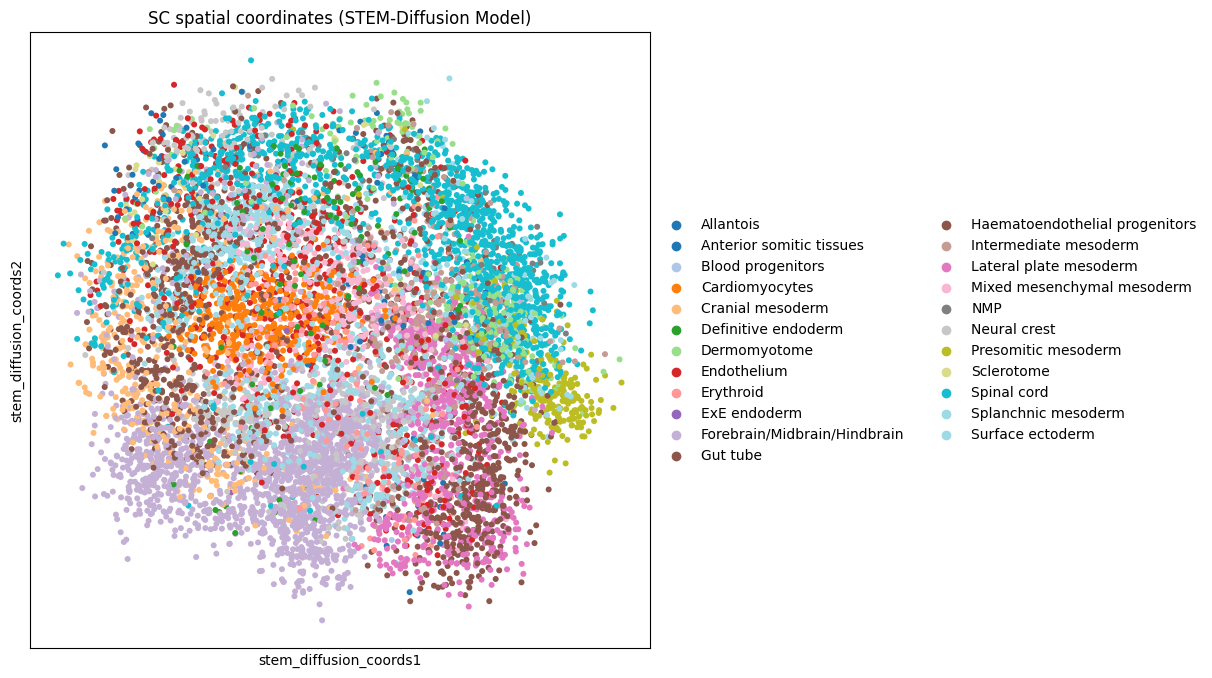

In [17]:
# Convert PyTorch tensor to NumPy array before assigning
if isinstance(sc_coords, torch.Tensor):
    sc_coords_np = sc_coords.cpu().numpy()
else:
    sc_coords_np = sc_coords

# Now assign the NumPy array to the obsm attribute
adata.obsm['stem_diffusion_coords'] = sc_coords_np

fig, ax = plt.subplots(figsize=(8, 8))  # your preferred size


# Visualization should now work
import scanpy as sc
sc.pl.embedding(adata, basis='stem_diffusion_coords', color='celltype_mapped_refined',
                size=75, title='SC spatial coordinates (STEM-Diffusion Model)',
                palette='tab20', legend_loc='right margin', legend_fontsize=10, ax=ax)